## DeepFake Detection Deep Learning Model Based on Tensorflow & CNN Architecture

**Problem Statement:** 

In today's digital world, the increase in fake images is causing worry, as these images can spread false information and reduce people's trust in the media space. In 2017, a new term "Deepfake" was introduced to denote synthetic generated fake images created by deep learning technology [1]. The technology is widely used for realistic face replacement in photos and videos, known as face-swapping. The use of face-swapping techniques by scammers and detractors has turned into powerful tools for manipulating people, financial fraud, and political subversion [2]. Using another person's face, without special permission, for any personal, business, political or other purposes violates principles of ethics of artificial intelligence [3]. Thus, the rapid development of artificial intelligence technology has given a new boost to improving the processing of images using a machine learning techniques such as Autoencoders and “Generative Adversarial Network” (GAN), which makes it difficult to distinguish real face images from fake ones. 

**Deepfake Image Example:**

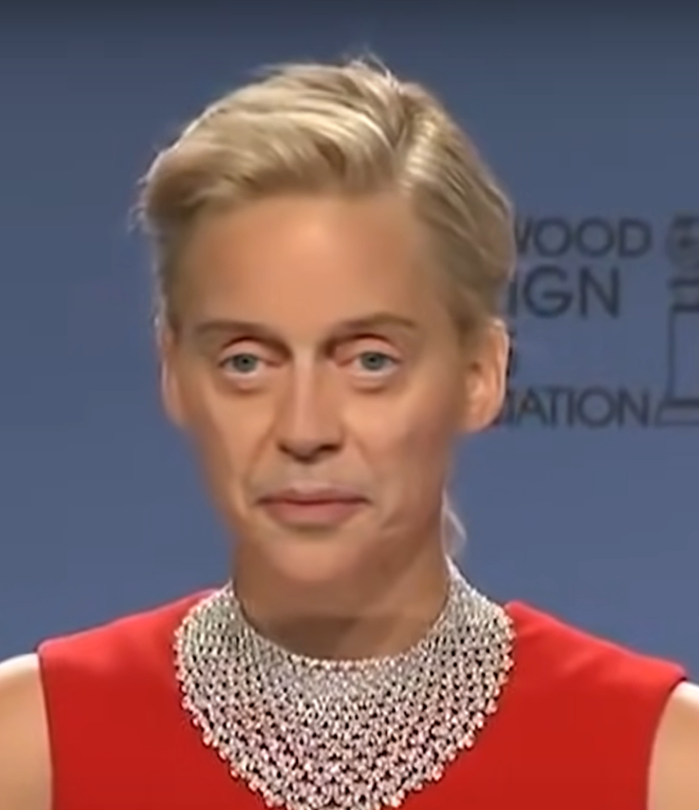

*Credits: Jennifer Lawrence + Steve Buscemi + Deepfake Image Generator => This Deepfake Image!*

**Dataset Description:** Pre-processed dataset of 224x224 resized real/fake images from "Deepfake Detection Challenge" (in 2019-2020, by Meta, AWS, Microsoft and the Partnership on AI’s Media Integrity Steering Committee) was used for training our "ReDeepFake" model. 

**Dataset Source:** [deepfake_faces](https://www.kaggle.com/datasets/dagnelies/deepfake-faces)

**Deepfake Detection Challenge:** [Deepfake Detection Challenge](https://www.kaggle.com/c/deepfake-detection-challenge)

**Final Trained Model Link:** [ReDeepFake v1.3](https://www.kaggle.com/models/armanzhalgasbayev/redeepfake)


## 1. Imports and Dependencies

In [1]:
# System & General libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import time
from collections import defaultdict

# Image Processing & Computer Vision
import cv2

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# Data Visualization
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_theme(style='whitegrid', palette='viridis', font_scale=1.2)

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Checking System Configurations

In [2]:
mp = defaultdict(lambda: "Not Present") 
mp['/device:GPU:0'] = 'GPU T4 x2'
if tf.test.is_gpu_available():
    device = tf.test.gpu_device_name()
    print(f'✅ GPU is available: {mp[device]}')
else:
    print('⚠️ No GPU available. Using CPU.')
print(f'🔸 Tensorflow Version: {tf.__version__}')

✅ GPU is available: GPU T4 x2
🔸 Tensorflow Version: 2.13.0


## 3. Load Data

In [3]:
def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

meta = get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


## 4. Exploratory Data Analysis
### 4.1. Metadata Summary

In [4]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['count'] = df.count().values
    summary_df['unique'] = df.nunique().values
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = df.isna().sum() / len(df)
    return summary_df
summary(meta).style.background_gradient('Purples')

,dtypes,count,unique,missing#,missing%
videoname,object,95634,95634,0,0.000000
original_width,int64,95634,31,0,0.000000
original_height,int64,95634,34,0,0.000000
label,object,95634,2,0,0.000000
original,object,79341,16955,16293,0.170368


In [5]:
print('Fake Images:', len(meta[meta.label=='FAKE']))
print('Real Images:', len(meta[meta.label=='REAL']))

Fake Images: 79341
Real Images: 16293


**1) Number of Fake and Real Images:**
* Fake Images: 79,341
* Real Images: 16,293

**2) Image Size:**
* Image size: 224x224 pixels
* Image size in bytes: 224 * 224 = 50,176 B (49 KB)

**3) Number of Images for Training:**
* To equally distribute images, we choose 10,000 real and 10,000 fake images.
* Total images for training = 16,000 (real) + 16,000 (fake) = 32,000 images.

**4) Total Dataset Size:**
* Total size of the dataset (with all image features) = Image size * Total images
* Total dataset size = 49 KB * 32,000 = 1,568,000 KB (or 1,531 MB)

> It's important to note that the total dataset size is approximately 1,531 MB (~ 1.5 GB), which poses a significant memory challenge especially for resource-constrained environments such as Kaggle Notebooks. Thus, we need to maximize the efficiency of our code for training. This includes optimizing data loading, preprocessing, and model training steps to ensure smooth execution within the limitations of our environment.

### 4.2. Real / Fake Data Distribution Normailzation

In [6]:
real_df = meta[meta['label'] == 'REAL']
fake_df = meta[meta['label'] == 'FAKE']
sample_size = 3000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

### 4.3. Training / Validation / Testing Sets

In [7]:
Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])

# (Rows, Columns)
print(f'Train Set: {Train_set.shape}')
print(f'Validation Set: {Val_set.shape}')
print(f'Test Set: {Test_set.shape}')

Train Set: (3360, 5)
Validation Set: (1440, 5)
Test Set: (1200, 5)


In [8]:
def plot_class_counts(train_set, val_set, test_set):
    sets = ['Train Set', 'Validation Set', 'Test Set']
    colors = ['#52A666', '#C15B4E']
    
    y = {
        'REAL': [np.sum(train_set == 'REAL'), np.sum(val_set == 'REAL'), np.sum(test_set == 'REAL')],
        'FAKE': [np.sum(train_set == 'FAKE'), np.sum(val_set == 'FAKE'), np.sum(test_set == 'FAKE')]
    }
    
    trace0 = go.Bar(x=sets, y=y['REAL'], name='REAL', marker={'color': colors[0]}, opacity=0.7)
    trace1 = go.Bar(x=sets, y=y['FAKE'], name='FAKE', marker={'color': colors[1]}, opacity=0.7)
    
    data = [trace0, trace1]
    layout = go.Layout(title='Count of Classes in each set:', xaxis={'title': 'Set'}, yaxis={'title': 'Count'})
    
    fig = go.Figure(data, layout)
    iplot(fig)
    
plot_class_counts(np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label']))

* **Training Set** is the portion of the dataset used to train the machine learning model.
* **Validation Set** is used to tune hyperparameters, such as learning rate or regularization strength, and to assess the model's performance during training.
* **Test Set** is entirely separate from the training and validation sets and is used to evaluate the final performance of the trained model.

### 4.4. Display sample of images from Dataset

In [ ]:
plt.figure(figsize=(15,15), dpi=300)
for idx,i in enumerate(Train_set.index[75:100]):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.xlabel('FAKE Image' if Train_set.loc[i,'label']=='FAKE' else 'REAL Image')

plt.tight_layout()
plt.show()

### 4.5. X / y Splitting of Sets

In [ ]:
# Function for getting image paths and corresponding labels from set
def retrieve_dataset(set_name):
    images, labels = [], []
    for (img, imgclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        labels.append(1 if imgclass == 'FAKE' else 0)
    return np.array(images), np.array(labels)

In [ ]:
%%time

X_train, y_train = retrieve_dataset(Train_set)
X_val, y_val = retrieve_dataset(Val_set)
X_test, y_test = retrieve_dataset(Test_set)

## 5. Model Training

### 5.1. Data Preprocessing

In [ ]:
%%time

tf.keras.backend.clear_session() # Clear previous session to avoid conflicts
tf.random.set_seed(42) 

batch_size = 16
preprocess = tf.keras.applications.efficientnet.preprocess_input  # EfficientNet preprocess function

# Convert dataset to -> TensorFlow datasets
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Preprocess and batch datasets [size: 16]
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

### 5.2. Building the model Architecture

* **Main Model Architecture:** The model architecture comprises the `EfficientNetB4` convolutional neural network, a powerful pre-trained feature extractor designed for image classification tasks. The base model is initialized with weights from the `imagenet` dataset, providing a strong foundation for learning hierarchical features.

`🔗 Source:` https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet

* **Additional Layers:** 
    * **Global average pooling layer** is employed to condense the spatial dimensions of the extracted features, creating a global context for the subsequent dense layer. 
    * **Dense layer with a sigmoid activation function** generating a single output representing the probability of the input image being a fake image.
    
* The model is compiled using the `stochastic gradient descent (SGD) optimizer`, with a `learning rate of 0.01` and `momentum of 0.9`, chosen to strike a balance between rapid convergence and stability. 

In [ ]:
%%time

# Build EfficientNetB4 model
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Additional layers for generating 1 concrete output
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Internal Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

# Apply Data Augmentation
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False) # using base model in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)


optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# model.summary()

### 5.3. Model Fitting with Training & Validation Sets

In [ ]:
%%time

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=25, # training will stop if there's no improvement in validation loss for 25 consecutive epochs
#     restore_best_weights=True, # estores the best weights when training stops
#     verbose=1
# )

# Train the model
history = model.fit(
    train_set, 
    validation_data=valid_set, 
    epochs=20
#     callbacks=[early_stopping]
)

## 6. Model Performance Evaluation

In [ ]:
# Visualize training history
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_mat = confusion_matrix(y_test, y_pred)

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

## 7. Save Final Model

In [ ]:
model.save('redeepfake_model.h5')

## 8. Model Reusing Guide

In [ ]:
model_path = 'redeepfake_model.h5'
model = tf.keras.models.load_model(model_path)

In [ ]:
os.listdir("/kaggle/input")

import os
print(os.listdir("/kaggle/input/deepfake-faces"))

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

In [ ]:
test_image_paths = []
for idx,i in enumerate(Test_set.index[125:150]):
    test_image_paths.append(('../input/deepfake-faces/faces_224/'+Test_set.loc[i,'videoname'][:-4]+'.jpg', Test_set.loc[i,'label']))

In [ ]:
plt.figure(figsize=(15,15), dpi=300)

for idx, (image_path, label) in enumerate(test_image_paths):
    processed_image = preprocess_image(image_path)
    processed_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(processed_image)
    
    # Threshold for binary classification: 0.33
    predicted_class = "FAKE" if prediction[0, 0] > 0.33 else "REAL"
    
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.xlabel(f'{predicted_class} | {prediction[0, 0]:.2f} | {"T" if predicted_class == label else "F"}')
    
plt.tight_layout()
plt.show()

## 9. Conclusion

In this research endeavor, we set out to develop an efficient deep learning model for the detection of fake images using the state-of-the-art EfficientNetB4 architecture. The model exhibited promising performance during training, achieving an impressive accuracy on the training set.

The high accuracy achieved on the training set underscores the effectiveness of the model in learning intricate patterns and features indicative of fake images. The utilization of transfer learning, leveraging the pre-trained EfficientNetB4 on ImageNet, provided a robust foundation for feature extraction. Fine-tuning hyperparameters, experimenting with different optimization algorithms, and exploring advanced architectures are promising directions for future research.

As we move forward, the research will focus on extensive validation and testing, ensuring the model's robustness and reliability in diverse scenarios. This work lays the foundation for contributing to the growing field of image forensics and fake image detection.

**Thank you for attention!**

## 10. References

1. Paine, L. (2024, Jan 16). Deepfake: AI-generated synthetic media. The encyclopedia of Britannica. Retrieved from https://b2a.kz/6mk 
2. Committee On Oversight and Accountability (2023, Nov 8). Mace: Deepfake Technology Can Be Weaponized to Cause Harm. Retrieved from https://b2a.kz/QSn 
3. Office of the Director of National Intelligence (n.d.). Principles of Artificial Intelligence Ethics for The Intelligence Community. Retrieved from https://b2a.kz/86p
4. Kirushikesh DB (2022). Deep Fake Detection on Images and Videos. Kaggle Notebook. Retrieved from https://www.kaggle.com/code/krooz0/deep-fake-detection-on-images-and-videos
5. dagnelies (2020). deepfake_faces. Kaggle Dataset. Retrieved from https://www.kaggle.com/datasets/dagnelies/deepfake-faces
6. Kaggle (2019). Deepfake Detection Challenge. Kaggle Competition. Retrieved from https://www.kaggle.com/c/deepfake-detection-challenge